In [6]:
import pandas as pd
import os, sys, importlib
sys.path.append(os.path.abspath(".."))
from utils import image_auto_annotation
import json

d:\miniconda3\envs\airbnb_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## TEST : autoclf

## labels2emb

In [42]:
## labels_text (prompt):
#？
# is_default_pic_labels = {
#     "1": "the official Airbnb default profile picture, a gray geometric human silhouette",
#     "0": "a normal user-uploaded profile picture"
# }

# has_person_labels = {
#     "1": "a photo that contains one or more people",
#     "0": "a photo without any people"
# }
# type_labels = {
#     "life": "a person shown in a real-life scene or activity, with visible environment or lifestyle context.",
#     "pro": "a clean portrait or headshot focused mainly on the face, with little or no background information.",
#     "UNK": "no visible person, or not enough information to determine lifestyle vs portrait."
# }

type_labels = {
    "life": 
        "a photo of a person in a visible daily scene or some activities",
    "pro": 
        "a portrait or headshot,focused mainly on the face, with little or no background information.",
    "UNK": 
        "an image without any people or cannot determine whether it is lifestyle or portrait"
}
# quality_labels = {
#     "high": 
#         "a clear, high-quality photo with good lighting and sharp details",
#     "low": 
#         "a low-quality photo with blur, noise, poor lighting or distortion",
#     "UNK": 
#         "quality cannot be determined"
# }
is_smiling_labels = {
    "1": "a person smiling visibly",
    "0": "a person not smiling",
    "UNK": "no person or cannot see their face"
}
sex_labels = {
    "M": "a photo of a man",
    "F": "a photo of a woman",
    "MIX": "a photo with multiple people of mixed gender",
    "UNK": "the gender of the person cannot be determined or no person present"
}
labels_text = {
    # "has_person": has_person_labels,
    # "is_default_pic": is_default_pic_labels,
    "type": type_labels,
    # "quality": quality_labels,
    "is_smiling": is_smiling_labels,
    "sex": sex_labels   
}


with open ("labels/labels_text.json","w", encoding='utf-8') as f :
    json.dump(labels_text, f, indent=2)


In [3]:
#labels images :

import json
labels_img={
  "type": {
    "identity_style": 
      ["106365215.jpg", "517697918.jpg",'163132965.jpg',"20701159.jpg"],
    "lifestyle": 
      ["1219743.jpg","13086789.jpg","14266056.jpg","17589377.jpg","228952775.jpg"],
    "UNK": 
    ["52801103.jpg","425502119.jpg","212791574.jpg"]      
  }
  # "is_smiling": {
  #   "1": "a person smiling visibly",
  #   "0": "a person not smiling",
  #   "UNK": "cannot see the face or cannot tell whether the person is smiling"
  # },
  # "sex": {
  #   "M": "a photo of a man",
  #   "F": "a photo of a woman",
  #   "MIX": "a photo with multiple people of mixed gender",
  #   "UNK": "the gender of the person cannot be determined or no person present"
  # }
}
life_imgs = ["106365215.jpg", "517697918.jpg",'163132965.jpg',"20701159.jpg"]
pro_imgs  = ["1219743.jpg","13086789.jpg","14266056.jpg","17589377.jpg","228952775.jpg"]
unk_imgs=["52801103.jpg","425502119.jpg","212791574.jpg",""]


with open ("labels/labels_img.json","w", encoding='utf-8') as f :
    json.dump(labels_img, f, indent=2)


In [4]:
labels_prompt={
  "type": {
    "identity_style": {
      "text": "a portrait-style photo of a person or people, showing mainly the face or upper body, in a simple or ordinary setting without any strong lifestyle context or activities",
      "images": ["106365215.jpg", "517697918.jpg",'163132965.jpg',"20701159.jpg"]
    },
    "lifestyle": {
      "text":"a photo of a person or people in a clear and meaningful real-life situation, such as traveling, doing sports, or engaging in daily activities, where the scene strongly reflects their lifestyle",
      "images": ["1219743.jpg","13086789.jpg","14266056.jpg","17589377.jpg","228952775.jpg"]
    },
    "UNK": {
      "text": "an image where it is unclear whether it shows a portrait-style photo or a meaningful lifestyle scene",
      "images": ["52801103.jpg","425502119.jpg","212791574.jpg"]      
    }
  },

  "is_smiling": {
    "1": {
      "text": "a person smiling visibly",
      "images": []
    },
    "0": {
      "text": "a person not smiling",
      "images": []
    },
    "UNK": {
      "text": "cannot see the face or cannot tell whether the person is smiling",
      "images": []
    }
  },

  "sex": {
    "M": {
      "text": "a photo of a man",
      "images": []
    },
    "F": {
      "text": "a photo of a woman",
      "images": []
    },
    "MIX": {
      "text": "a photo with multiple people of mixed gender",
      "images": []
    },
    "UNK": {
      "text": "the gender of the person cannot be determined or no person present",
      "images": []
    }
  }
}

with open ("labels/labels_prompt.json","w", encoding='utf-8') as f :
    json.dump(labels_prompt, f, indent=2)



## emb text prompt V1


In [43]:
# embed labels :
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel
device='cuda' if torch.cuda.is_available() else "cpu" 
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

d:\miniconda3\envs\airbnb_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# 1) 读取你的 labels JSON
with open("labels/labels_text.json", "r") as f:
    labels_text = json.load(f)

def embed_text_by_clip(text_list):
    """
    text_list: list of strings
    return: np.array of shape (len(text_list), embedding_dim)
    label 被省去，只留下具体描述

    """
    with torch.no_grad():
        inputs = processor(text=text_list, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**inputs)  # (N, 512)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features.cpu().numpy().astype("float32")

# 2) 生成 embedding
labels_emb = {}
for category, dic in labels_text.items():
    texts = list(dic.values())  # e.g. ["life prompt", "pro prompt", "UNK prompt"]
    emb = embed_text_by_clip(texts)  # shape = (num_classes, 512)
    labels_emb[category] = emb


# 3) 保存到单个 npz 文件
np.savez("labels/labels_emb.npz", **labels_emb)
print("[SUCCES] Saved text embeddings → labels/labels_emb.npz")


[SUCCES] Saved text embeddings → labels/labels_emb.npz


## emb text prompt V2 : few-shot


In [ ]:
import json, pickle
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel

device = 'cuda' if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


def embed_text_by_clip(text_list):
    with torch.no_grad():
        inputs = processor(text=text_list, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features.cpu().numpy().astype("float32")




# ---- 1) 读取文本标签 ----
with open("labels/labels_text.json", "r") as f:
    labels_text = json.load(f)

# ---- 2) 对所有文本生成 embedding ----
labels_emb = {}
for category, dic in labels_text.items():
    texts = list(dic.values())
    emb = embed_text_by_clip(texts)
    # 按字典顺序对应回 keys
    labels_emb[category] = {
        cls_name: emb[i:i+1]
        for i, cls_name in enumerate(dic.keys())
    }

# ---- 3) 给 “type” 类别加入 example images embeddings ----

# 加载 image embeddings
img_embeddings_path="embeddings_SAMPLE/emb_SAMPLE.npz"
img_embs = np.load(img_embeddings_path)

# 你自己挑一些示例图片:
life_imgs = ["106365215.jpg", "517697918.jpg",'163132965.jpg',"20701159.jpg"]
pro_imgs  = ["1219743.jpg","13086789.jpg","14266056.jpg","17589377.jpg","228952775.jpg"]
unk_imgs=["52801103.jpg","425502119.jpg","212791574.jpg",""]

final_type_emb = {}
for cls_name, emb_text in labels_emb["type"].items():
    all_embs = [emb_text]  # start with text prompt emb

    if cls_name == "life":
        for f in life_imgs:
            all_embs.append(img_embs[f][None])
    if cls_name == "pro":
        for f in pro_imgs:
            all_embs.append(img_embs[f][None])
    if cls_name=='UNK':
        for f in unk_imgs:
            all_embs.append(img_embs[f][None])

    final_type_emb[cls_name] = np.vstack(all_embs)

# 覆盖原来的 type
labels_emb["type"] = final_type_emb

# ---- 4) 保存为 pkl（支持嵌套结构） ----
with open("labels/labels_emb_txt-img.pkl", "wb") as f:
    pickle.dump(labels_emb, f)

print("[SUCCES] Saved → labels/labels/labels_emb_txt-img.pkl")

[SUCCES] Saved → labels/labels/labels_emb_txt-img.pkl


## emb txt img V3 :

In [14]:
import importlib
importlib.reload(image_auto_annotation)
from utils.image_auto_annotation import embed_labels_txt_img

In [16]:
labels_emb=embed_labels_txt_img(labels_prompt_path='labels/labels_prompt.json',
                         image_emb_path="embeddings/emb_TEST.npz",
                         labels_emb_path="labels/labels_emb_txt-img.pkl")


# 检查每个类别的向量 shape
for category, cls_dict in labels_emb.items():
    print(f"Category: {category}")
    for cls_name, emb in cls_dict.items():
        print(f"  Class: {cls_name}, embedding shape: {emb.shape}")

======================EMBEDDING TEXT + FEW SHOT IMG=======================

[SUCCES] labels text-image prompt embeded by 'openai/clip-vit-base-patch32' saved to 'labels/labels_emb_txt-img.pkl' : 5.78 sec!

Category: type
  Class: identity_style, embedding shape: (5, 512)
  Class: lifestyle, embedding shape: (6, 512)
  Class: UNK, embedding shape: (4, 512)
Category: is_smiling
  Class: 1, embedding shape: (1, 512)
  Class: 0, embedding shape: (1, 512)
  Class: UNK, embedding shape: (1, 512)
Category: sex
  Class: M, embedding shape: (1, 512)
  Class: F, embedding shape: (1, 512)
  Class: MIX, embedding shape: (1, 512)
  Class: UNK, embedding shape: (1, 512)


## PREDICTION

In [ ]:
import numpy as np
import json
import os
import pickle
from tqdm import tqdm
import time
start_time=time.time()

# ------------------------
# 文件路径
# ------------------------
image_emb_path = "embeddings_SAMPLE/emb_SAMPLE.npz"
text_emb_path = "labels/labels_emb_txt-img.pkl"
text_json_path = "labels/labels_text.json"
output_json_path = "annotations_SAMPLE/autoclf_predictions.json"

# ------------------------
# 读取 embeddings
# ------------------------
image_embs = np.load(image_emb_path)  # keys: "host_id.jpg"

with open(text_emb_path, "rb") as f:
    labels_emb = pickle.load(f)

with open(text_json_path, "r") as f:
    labels_text = json.load(f)
default_pic_emb=image_embs["336591839.jpg"]


# ------------------------
# 预测函数
# ------------------------
def is_default_pic(image_emb, default_pic_emb, threshold=0.95):
    """
    image_emb: np.array (512,)
    default_emb: np.array (512,)
    threshold: cosine similarity threshold
    """
    sim = image_emb @ default_pic_emb  # cosine similarity, embeddings 已经 L2-normalized
    return "1" if sim >= threshold else "0"

def zero_shot_predict(img_emb, text_emb_dict):
    """
    img_emb: np.array (512,)
    text_emb_dict: np.array (num_classes, 512)
    """
    sims = img_emb @ text_emb_dict.T        # cosine similarity
    idx = np.argmax(sims)
    return idx, sims

import numpy as np


def few_shot_predict(img_emb, support_dict):
    """
    img_emb: (512,)
    support_dict: dict[class_name -> (N,512)]  
        每个类别可以有文本embedding和示例图片embedding
    返回：类别名
    """
    best_cls = None
    best_sim = -999

    for cls_name, emb_set in support_dict.items():  # emb_set shape = (K,512)
        sims = img_emb @ emb_set.T                  # → (K,)
        score = sims.max()                          # 取最大相似度

        if score > best_sim:
            best_sim = score
            best_cls = cls_name

    return best_cls



# ------------------------
# 遍历每张图片
# ------------------------


from tqdm import tqdm

predictions = {}

for fname in tqdm(image_embs.files, desc='predict on images...'):
    img_emb = image_embs[fname]

    pred = {}

    # ---- 1) 默认头像判断 ----
    pred["is_default_pic"] = is_default_pic(img_emb, default_pic_emb)

    # 如果是默认头像，直接覆盖其他标签
    if pred["is_default_pic"] == "1":
        pred.update({
            "type": "UNK",
            "is_smiling": "UNK",
            "sex": "UNK"
        })
        predictions[fname] = pred
        continue

    # ---- 2) few-shot 预测其他类别 ----
    for category in labels_emb.keys():
        if category == "is_default_pic":
            continue #跳过当前循环的剩余部分，直接进入下一次循环

        support_dict = labels_emb[category]  # dict[class_name -> (N,512)]
        best_cls = few_shot_predict(img_emb, support_dict)

        pred[category] = best_cls

    predictions[fname] = pred

# ------------------------
# 保存 JSON
# ------------------------
with open(output_json_path, "w") as f:
    json.dump(predictions, f, indent=2)

end_time=time.time()
print(f"✅ Auto predictions on {len(image_embs)} images saved → {output_json_path}: {end_time-start_time:.2f} sec!")
print(predictions)

predict on images...: 100%|██████████| 20/20 [00:00<00:00, 5054.60it/s]

✅ Auto predictions on 20 images saved → annotations_SAMPLE/autoclf_predictions.json: 0.01 sec!
{'102571900.jpg': {'is_default_pic': '0', 'type': 'pro', 'is_smiling': '1', 'sex': 'F'}, '106294215.jpg': {'is_default_pic': '0', 'type': 'life', 'is_smiling': 'UNK', 'sex': 'UNK'}, '106365215.jpg': {'is_default_pic': '0', 'type': 'life', 'is_smiling': '1', 'sex': 'M'}, '137154154.jpg': {'is_default_pic': '0', 'type': 'life', 'is_smiling': 'UNK', 'sex': 'F'}, '212791574.jpg': {'is_default_pic': '0', 'type': 'UNK', 'is_smiling': '0', 'sex': 'UNK'}, '2379345.jpg': {'is_default_pic': '0', 'type': 'UNK', 'is_smiling': '0', 'sex': 'UNK'}, '24654560.jpg': {'is_default_pic': '0', 'type': 'UNK', 'is_smiling': 'UNK', 'sex': 'MIX'}, '2798386.jpg': {'is_default_pic': '0', 'type': 'pro', 'is_smiling': '1', 'sex': 'M'}, '28470251.jpg': {'is_default_pic': '0', 'type': 'pro', 'is_smiling': '1', 'sex': 'F'}, '32741638.jpg': {'is_default_pic': '0', 'type': 'pro', 'is_smiling': '1', 'sex': 'F'}, '336591839.jpg

## DETECTION:

In [37]:
import os
import json
from ultralytics import YOLO
from PIL import Image
from tqdm import tqdm
import time
from PIL import Image
import cv2
import numpy as np


# -------------------------------------------------
# 1. 加载 YOLO 模型（最轻量 CPU/GPU 通吃）
# -------------------------------------------------
model = YOLO("yolov8n.pt")

# -------------------------------------------------
# 2. quality 判断（基于最短边 px）
# -------------------------------------------------
# def get_quality_label(img_path,short_edge_threshold=150):
#     try:
#         img = Image.open(img_path)
#         w, h = img.size
#         short_edge = min(w, h)

#         # 根据 Airbnb 头像特点：200px 以下几乎肯定 low
#         if short_edge >= short_edge_threshold:
#             return "high"
#         else:
#             return "low"
#     except:
#         return "UNK"

def get_quality_label(img_path, blur_threshold=100.0):
    """
    根据图像是否模糊判断质量
    img_path: 图片路径
    blur_threshold: Laplacian 方差阈值，值越小越模糊
    return: "high" 或 "low"
    """
    try:
        # 用 PIL 读取并转为灰度
        img = Image.open(img_path).convert("L")  
        img_np = np.array(img)

        # Laplacian 方差
        lap_var = cv2.Laplacian(img_np, cv2.CV_64F).var()

        if lap_var >= blur_threshold:
            return "high"
        else:
            return "low"
    except Exception as e:
        print(f"[ERROR] Failed to process {img_path}: {e}")
        return "low"

# -------------------------------------------------
# 3. YOLO 判断 has_person
# -------------------------------------------------
def detect_has_person(img_path):
    try:
        # results = model(img_path)[0]  # first result
        results = model(img_path, verbose=False)[0]  # 👈 关闭所有日志输出
        for box in results.boxes:
            cls = int(box.cls[0])
            if results.names[cls] == "person":
                return "1"
        return "0"
    except:
        return "UNK"

# -------------------------------------------------
# 4. main pipeline
# -------------------------------------------------
def detect_person_and_quality(
        images_folder="images_SAMPLE",
        save_json="annotations_SAMPLE/detections.json"
    ):
    start_time=time.time()

    os.makedirs(os.path.dirname(save_json), exist_ok=True)
    records = {}

    image_files = [f for f in os.listdir(images_folder) if f.lower().endswith((".jpg",".jpeg",".png"))]

    # print(f"[INFO] Found {len(image_files)} images in {images_folder}")

    for fname in tqdm(image_files, desc="detecting has_person and picture quality..."):
        fpath = os.path.join(images_folder, fname)

        # YOLO: detect person
        has_person = detect_has_person(fpath)

        # quality: size-based
        quality = get_quality_label(fpath)

        records[fname] = {
            "has_person": has_person,
            "quality": quality
        }

        # print(f"[OK] {fname} → has_person={has_person}, quality={quality}")

    # save json
    with open(save_json, "w") as f:
        json.dump(records, f, indent=2)
    end_time=time.time()

    print(f"[SUCCES] {len(image_files)} detection results saved to {save_json} :{end_time-start_time:.2f} sec!")
    return records

# # -------------------------------------------------
# # Run
# # -------------------------------------------------
# if __name__ == "__main__":
#     run_yolo_pipeline()


detect_person_and_quality(
        images_folder="images_SAMPLE",
        save_json="annotations_SAMPLE/detections.json"
    )

detecting has_person and picture quality...: 100%|██████████| 20/20 [00:00<00:00, 20.02it/s]

[SUCCES] 20 detection results saved to annotations_SAMPLE/detections.json :1.00 sec!


{'102571900.jpg': {'has_person': '1', 'quality': 'high'},
 '106294215.jpg': {'has_person': '0', 'quality': 'high'},
 '106365215.jpg': {'has_person': '1', 'quality': 'high'},
 '137154154.jpg': {'has_person': '1', 'quality': 'high'},
 '212791574.jpg': {'has_person': '0', 'quality': 'high'},
 '2379345.jpg': {'has_person': '0', 'quality': 'high'},
 '24654560.jpg': {'has_person': '1', 'quality': 'high'},
 '2798386.jpg': {'has_person': '1', 'quality': 'high'},
 '28470251.jpg': {'has_person': '1', 'quality': 'high'},
 '32741638.jpg': {'has_person': '0', 'quality': 'low'},
 '336591839.jpg': {'has_person': '0', 'quality': 'low'},
 '425502119.jpg': {'has_person': '0', 'quality': 'high'},
 '517697918.jpg': {'has_person': '1', 'quality': 'high'},
 '52438163.jpg': {'has_person': '1', 'quality': 'high'},
 '52801103.jpg': {'has_person': '0', 'quality': 'low'},
 '553099349.jpg': {'has_person': '1', 'quality': 'low'},
 '57226046.jpg': {'has_person': '1', 'quality': 'high'},
 '71320446.jpg': {'has_perso

## merge prediction and detection:

In [ ]:
import json

def read_json(json_path):
    with open(json_path, 'r', encoding='utf-8')as f:
        data=json.load(f)
    return data

def apply_override_rules (annos):
    """
    {
    "is_default_pic": "1",
    "type": "UNK",
    "is_smiling": "UNK",
    "sex": "UNK",
    "has_person": "0",
    "quality": "UNK"
    },
    {...}

    """
    if annos['is_default_pic']==1:
        return {
            "is_default_pic": "1",
            "type": "UNK",
            "is_smiling": "UNK",
            "sex": "UNK",
            "has_person": "0",
            "quality": "low"
            }       

    elif annos['has_person']==0:#no person
        return { 
            "is_default_pic": "0",
            "type": "UNK",
            "is_smiling": "UNK",
            "sex": "UNK",
            "has_person": "0",
            "quality": annos['quality']
        }
        
    else :
        return annos


def merge_annotations (detection_path, prediction_path, auto_annotations_path):
    print("**PROCESS** merging detections and predictions...")
    detections=read_json(detection_path)
    predictions=read_json(prediction_path)
    print(f"[INFO] keys alignement: {predictions.keys()==detections.keys()}")# check

    merged = {}
    for fname in predictions.keys():
        merged[fname] = {}  # 新建子字典

        # 1. 先放 CLIP/few-shot 预测结果
        if fname in predictions:
            merged[fname].update(predictions[fname])

        # 2. 再放 YOLO detections
        if fname in detections:
            merged[fname].update(detections[fname])

        # 3. OVERRIDE:
        updated_annos=apply_override_rules(merged[fname])
        merged[fname]=updated_annos

    # 4. 保存为 json
    with open(auto_annotations_path, "w") as f:
        json.dump(merged, f, indent=2)
    print(f"[SAVE] merged and overrided auto-annotations saved in {auto_annotations_path}!\n")
    return 


detection_path="annotations_SAMPLE/detections.json"
prediction_path="annotations_SAMPLE/autoclf_predictions.json"
auto_annotations_path="annotations_SAMPLE/auto_annotations.json"
merge_annotations (detection_path, prediction_path, auto_annotations_path)


**PROCESS** merging detections and predictions...
[INFO] keys alignement: True
[SAVE] merged and overrided auto-annotations saved in annotations_SAMPLE/auto_annotations.json!



## evaluatation of autoclf

In [41]:
## evaluation of clip:
import json
from sklearn.metrics import f1_score, classification_report
#load annotations :
ls_annotations_path="annotations_SAMPLE/ls_annotations.json"#y_true
auto_annotations_path="annotations_SAMPLE/auto_annotations.json"#y_pred
ls_annotations_brut=read_json(ls_annotations_path)
auto_annotations=read_json(auto_annotations_path)

# parse ls_annotations:

def ls_to_dict(ls_json):
    """
    ls_json: list, LabelStudio 导出 json
    return: dict {filename: {dim:value}}
    """
    out = {}
    for item in ls_json:
        # 找到图片名
        fname = item.get("data", {}).get("filename") or item.get("file_upload")
        if not fname:
            continue
        
        # 取第一条标注（annotations 可能有多人标注，取第一个即可）
        ann_list = item.get("annotations", [])
        if not ann_list:
            continue
        
        ann_result = ann_list[0].get("result", [])
        labels = {}
        for r in ann_result:
            dim = r.get("from_name")
            value_dict = r.get("value", {})
            # choices 是 LabelStudio 默认格式
            if "choices" in value_dict and len(value_dict["choices"]) > 0:
                labels[dim] = value_dict["choices"][0]
            else:
                labels[dim] = "UNK"  # 没有标注就填 UNK

        out[fname] = labels
    return out

ls_annotations = ls_to_dict(ls_annotations_brut)
# print(ls_annotations)


# evaluation:
import pandas as pd
from sklearn.metrics import classification_report, f1_score
import json

def summarize_classification(auto_annos, ls_annos, label_dims=None):
    """
    auto_annos: dict {filename: {dim: label}}
    ls_annos: dict {filename: {dim: label}}  # ground truth
    label_dims: list of dimensions to evaluate, e.g. ["type","quality",...]
    F1:
    宏平均 (macro)：每个类别 F1 平均 → 类别不平衡敏感
    微平均 (micro)：全局 TP/FP/FN 计算 → 对样本量敏感


    返回 DataFrame，可直接打印或保存 CSV
    """
    if label_dims is None:
        # 从 ground truth 取所有维度
        label_dims = list(next(iter(ls_annos.values())).keys())
    
    records = []
    
    for dim in label_dims:
        y_true = []
        y_pred = []
        unk_count = 0
        for fname in ls_annos:
            true_label = ls_annos[fname].get(dim, "UNK")
            pred_label = auto_annos.get(fname, {}).get(dim, "UNK")
            y_true.append(true_label)
            y_pred.append(pred_label)
            if true_label == "UNK":
                unk_count += 1
        
        # classification report
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
        # macro avg f1
        # macro_f1 = report["macro avg"]["f1-score"]

        # macro f1
        macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # micro f1
        micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
        # accuracy
        # acc = report["accuracy"]
        acc = sum([t==p for t,p in zip(y_true, y_pred)]) / len(y_true)


        records.append({
            "dimension": dim,
            "accuracy": acc,
            "macro_f1": macro_f1,
            "micro_f1":micro_f1,
            "UNK_count": unk_count,
            "low_performance_flag": micro_f1 < 0.7  # 标记 F1 < 0.7
        })
    
    df_summary = pd.DataFrame(records)
    return df_summary


dims = ["is_default_pic","has_person","type", "quality","is_smiling","sex"]
df_summary=summarize_classification(auto_annos=auto_annotations, ls_annos=ls_annotations, label_dims=dims)
display(df_summary)



,dimension,accuracy,macro_f1,micro_f1,UNK_count,low_performance_flag
0,is_default_pic,1.00,1.000000,1.00,0,False
1,has_person,0.90,0.890110,0.90,0,False
2,type,0.70,0.707143,0.70,6,False
3,quality,0.70,0.438272,0.70,1,False
4,is_smiling,0.75,0.660131,0.75,9,False
5,sex,0.90,0.918831,0.90,7,False


In [33]:

y_true = {dim: [] for dim in dims}
y_pred = {dim: [] for dim in dims}
##格式：{'is_default_pic': ['0','0', '0', ...], "has_person":[]}

for fname in ls_annotations.keys():
    if fname not in auto_annotations:
        continue
    gt = ls_annotations[fname]
    pred = auto_annotations[fname]

    for dim in dims:
        y_true[dim].append(gt.get(dim, "UNK"))
        y_pred[dim].append(pred.get(dim, "UNK"))

for dim in dims:
    print(f"--------------------{dim}-----------------------")
    print(classification_report(y_true[dim], y_pred[dim], zero_division=0),'\n')


--------------------is_default_pic-----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 

--------------------has_person-----------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.86      0.92        14

    accuracy                           0.90        20
   macro avg       0.88      0.93      0.89        20
weighted avg       0.93      0.90      0.90        20
 

--------------------type-----------------------
              precision    recall  f1-score   support

         UNK       0.60      1.00      0.75         6
        life       1.00      0.40      0.57        10
         pro       

## check:

In [ ]:
# #检查images, annot, pred 的keys是否对应！！
# import os
# import json
# with open("annotations_SAMPLE/autoclf_predictions.json", "r", encoding='utf-8')as j:
#     predictions=json.load(j)
# print(predictions)
# pred_keys=predictions.keys()
# print(len(predictions))


# sample_keys=[k for k in os.listdir('images_SAMPLE') if k.endswith('.jpg')]
# print(sample_keys)
# inter=set(annot_keys).intersection(set(pred_keys))
# print(inter)
# print(len(inter))


# inter=set(sample_keys).intersection(set(pred_keys))
# print(inter)
# print(len(inter))

## eval:

## ls name :

In [54]:
from utils.image_auto_annotation import ls_to_dict, read_json, get_quality_label


In [55]:
ls_dict=read_json("annotations_TEST\ls_annotations.json")
out=ls_to_dict(ls_dict)
print(out['10049969.jpg'])

{'is_default_pic': '0', 'has_person': '1', 'type': 'identity_style', 'quality': 'low', 'sex': 'F', 'is_smiling': '1'}


In [60]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

def get_quality_label(img_path):
    """
    计算 Laplacian 方差作为 blur 指标
    return: lap_var
    """
    try:
        img = Image.open(img_path).convert("L")
        img_np = np.array(img)
        lap_var = cv2.Laplacian(img_np, cv2.CV_64F).var()
        return lap_var
    except Exception as e:
        print(f"[ERROR] Failed to process {img_path}: {e}")
        return None

def show_quality_samples_with_blur(ls_annos, image_root, n=6, figsize=(12, 6)):
    """
    显示 quality=high / low 样本各 n 张，并显示 Laplacian 方差
    """
    highs = [f for f, ann in ls_annos.items() if ann.get("quality") == "high"]
    lows  = [f for f, ann in ls_annos.items() if ann.get("quality") == "low"]

    highs_sample = random.sample(highs, min(n, len(highs)))
    lows_sample  = random.sample(lows, min(n, len(lows)))

    cols = n
    rows = 2
    plt.figure(figsize=figsize)

    # high
    for i, fname in enumerate(highs_sample):
        img_path = os.path.join(image_root, fname)
        try:
            img = Image.open(img_path)
        except:
            continue
        lap_var = get_quality_label(img_path)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        ann = ls_annos[fname]
        text = "\n".join([f"{k}:{v}" for k,v in ann.items()])
        plt.title(f"[HIGH]\n{fname}\nlap:{lap_var:.1f}\n{text}", fontsize=7)

    # low
    for i, fname in enumerate(lows_sample):
        img_path = os.path.join(image_root, fname)
        try:
            img = Image.open(img_path)
        except:
            continue
        lap_var = get_quality_label(img_path)

        plt.subplot(rows, cols, cols+i+1)
        plt.imshow(img)
        plt.axis("off")
        ann = ls_annos[fname]
        text = "\n".join([f"{k}:{v}" for k,v in ann.items()])
        plt.title(f"[LOW]\n{fname}\nlap:{lap_var:.1f}\n{text}", fontsize=7)

    plt.tight_layout()
    plt.show()


In [61]:
# quality threshold check：
import random
import os
from PIL import Image
import matplotlib.pyplot as plt


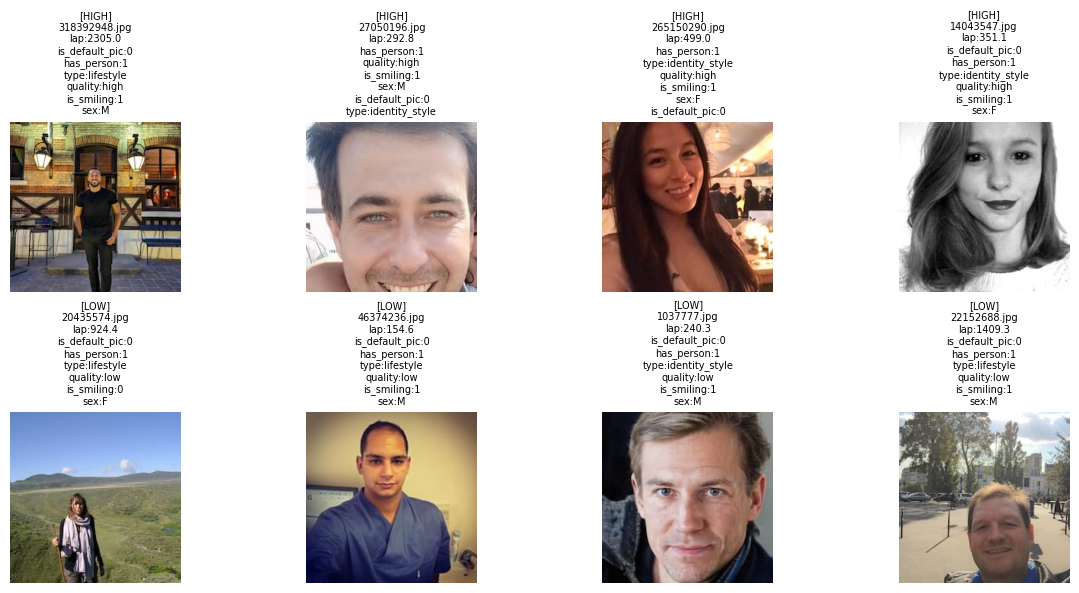

In [63]:
ls_annotations_brut = read_json("annotations_TEST/ls_annotations.json")
ls_annos = ls_to_dict(ls_annotations_brut)

show_quality_samples_with_blur(ls_annos, image_root="images_TEST", n=4)


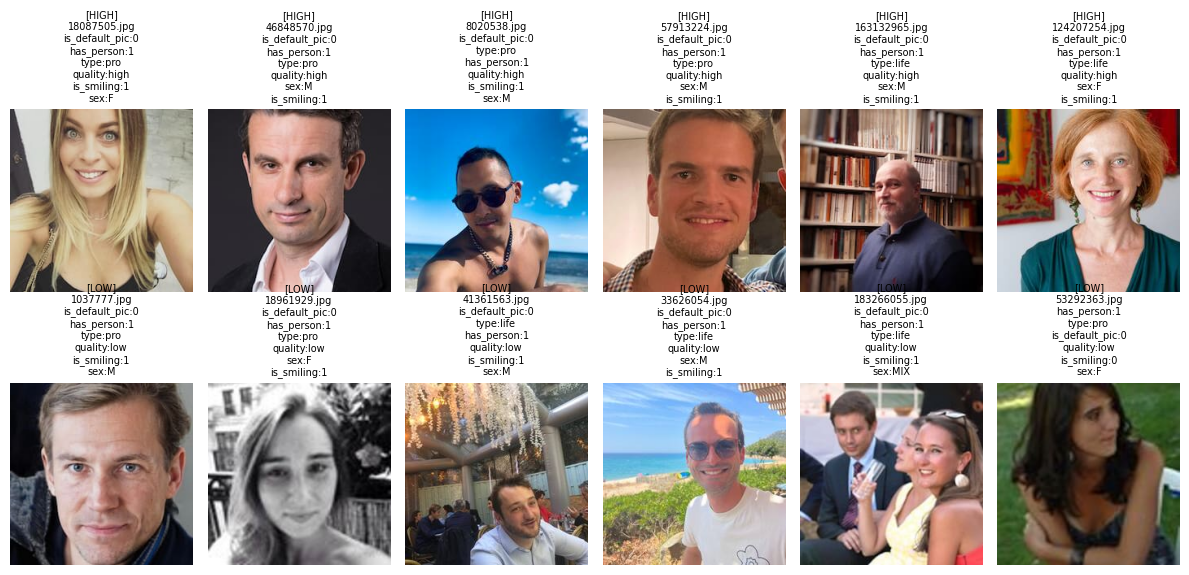

(['18087505.jpg',
  '46848570.jpg',
  '8020538.jpg',
  '57913224.jpg',
  '163132965.jpg',
  '124207254.jpg'],
 ['1037777.jpg',
  '18961929.jpg',
  '41361563.jpg',
  '33626054.jpg',
  '183266055.jpg',
  '53292363.jpg'])

In [ ]:
ls_annotations_brut = read_json("annotations_TEST/ls_annotations.json")
ls_annos = ls_to_dict(ls_annotations_brut)

show_quality_samples(ls_annos, image_root="images_TEST", n=6)


# APPLICATION:

In [70]:
import importlib
from utils import image_auto_annotation
importlib.reload(image_auto_annotation)
from utils.image_auto_annotation import autoclf

In [ ]:
# images_folder="images_SAMPLE"
# image_emb_path="embeddings_SAMPLE/emb_SAMPLE.npz"
# labels_text_path="labels/labels_text.json"
# labels_emb_path="labels/labels_emb_txt-img.pkl"

# prediction_path="annotations_SAMPLE/autoclf_predictions.json"
# detection_path="annotations_SAMPLE/detections.json"
# auto_annotations_path="annotations_SAMPLE/auto_annotations.json"
# ls_annotations_path="annotations_SAMPLE/ls_annotations.json"

# autoclf(images_folder,
#             image_emb_path,
#             labels_text_path, 
#             labels_emb_path,
#             prediction_path,
#             detection_path,
#             auto_annotations_path,
#             ls_annotations_path)

======================EMBEDDING + FEW SHOT=======================

[SUCCES] labels text saved to labels/labels_text.json!
[SUCCES] labels text-image prompt embeded by openai/clip-vit-base-patch32 saved to labels/labels_emb_txt-img.pkl!

============================PREDICTION==============================
-is_default_pic:'1'/'0'
-type : life/pro/UNK (text prompt+few-shot)
-is_smiling: '1'/'0'/'UNK'
-sex: :M/F/MIX/UNK 



predict on images...: 100%|██████████| 20/20 [00:00<00:00, 2659.00it/s]


[SUCCES] Auto predictions on 20 images saved → annotations_SAMPLE/autoclf_predictions.json!

============================DETECTION===============================
-has_person by yolo:'1'/'0',
quality by Laplacian : high/low/UNK



detecting has_person and picture quality...: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]

[SUCCES] 20 detection results saved to annotations_SAMPLE/detections.json!

==============================MERGE=============================
merging detections and predictions...

[CHECK] keys alignement: True
[SAVE] merged and overrided auto-annotations saved in annotations_SAMPLE/auto_annotations.json!

==============================EVALUATION============================
ls_annotations : y_true,
auto_annotations:y_pred

classification report:


,dimension,accuracy,macro_f1,micro_f1,UNK_count,low_performance_flag
0,is_default_pic,1.00,1.000000,1.00,0,False
1,has_person,0.90,0.890110,0.90,0,False
2,type,0.70,0.707143,0.70,6,False
3,quality,0.70,0.438272,0.70,1,False
4,is_smiling,0.75,0.660131,0.75,9,False
5,sex,0.90,0.918831,0.90,7,False


Embeddings-> Prediction-> Detection-> Merge-> Evaluation 
20 images in images_SAMPLE :6.60 sec! 



In [ ]:
#label text-img emb不变，不需要重新embedded
labels_prompt_path="labels/labels_prompt.json"
labels_emb_path="labels/labels_emb_txt-img.pkl"

images_folder="images_SAMPLE"
image_emb_path="embeddings_SAMPLE/emb_SAMPLE.npz"

anno_folder='annotations_SAMPLE'

prediction_path=os.path.join(anno_folder,"predictions.json")
detection_path=os.path.join(anno_folder,"detections.json")
auto_annotations_path=os.path.join(anno_folder,"auto_annotations.json")
ls_annotations_path=os.path.join(anno_folder,"ls_annotations.json")




autoclf(images_folder,
            image_emb_path,
            labels_prompt_path, 
            labels_emb_path,
            prediction_path,
            detection_path,
            auto_annotations_path,
            ls_annotations_path,
            blur_threshold=700,
            low_flag_v=0.7,
            update_prompt=False)


============================PREDICTION==============================
-is_default_pic:'1'/'0'
-type : life/pro/UNK (text prompt+few-shot)
-is_smiling: '1'/'0'/'UNK'
-sex: :M/F/MIX/UNK 



predict on images...: 100%|██████████| 20/20 [00:00<00:00, 12178.58it/s]


[SUCCES] Auto predictions on 20 images saved → annotations_SAMPLE\predictions.json: 0.01 sec!

============================DETECTION===============================
- has_person by yolo:'1'/'0',
- quality by Laplacian : high/low/UNK



detecting has_person and picture quality...: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]

[SUCCES] 20 detection results saved to annotations_SAMPLE\detections.json 2.26 sec!

==============================MERGE=============================
merging detections and predictions...

[CHECK] keys alignement: True
[SAVE] merged and overrided auto-annotations saved in annotations_SAMPLE\auto_annotations.json!

==============================EVALUATION============================
ls_annotations : y_true,
auto_annotations:y_pred

=== Checking label consistency between ls_annos and auto_annos ===

 [WARNING] Label mismatch in dimension: 'quality'
   LS annotations labels:   ['UNK', 'high', 'low']
   Auto annotations labels: ['high', 'low']
   → Labels only in LS (missing in auto): ['UNK']
   Suggestion: Please check label names / mapping or CLIP text prompts.


----------------------------------------------
⚠️  Low performance detected for DIMENSION: **type**
Accuracy=0.500, Macro-F1=0.449, Micro-F1=0.500
----------------------------------------------
                precision    recal

,dimension,accuracy,macro_f1,micro_f1,UNK_count,low_performance_flag
0,is_default_pic,1.0,1.000000,1.0,0,False
1,has_person,0.9,0.890110,0.9,0,False
2,type,0.5,0.449084,0.5,6,True
3,quality,0.6,0.407407,0.6,1,True
4,is_smiling,0.7,0.619748,0.7,9,False
5,sex,0.9,0.918831,0.9,7,False


[PROCESS] Embeddings-> Prediction-> Detection-> Merge-> Evaluation 
20 images in images_SAMPLE :2.29 sec! 



In [72]:
#label text-img emb不变，不需要重新embedded
labels_prompt_path="labels/labels_prompt.json"
labels_emb_path="labels/labels_emb_txt-img.pkl"

images_folder="images_TEST"
image_emb_path="embeddings/emb_TEST.npz"

anno_folder='annotations_TEST'

prediction_path=os.path.join(anno_folder,"predictions.json")
detection_path=os.path.join(anno_folder,"detections.json")
auto_annotations_path=os.path.join(anno_folder,"auto_annotations.json")
ls_annotations_path=os.path.join(anno_folder,"ls_annotations.json")

autoclf(images_folder,
            image_emb_path,
            labels_prompt_path, 
            labels_emb_path,
            prediction_path,
            detection_path,
            auto_annotations_path,
            ls_annotations_path,
            low_flag_v=0.7, 
            update_prompt=True)

##clip非常快！yolo偏慢，半分钟。

======================EMBEDDING TEXT + FEW SHOT IMG=======================

[SUCCES] labels text-image prompt embeded by 'openai/clip-vit-base-patch32' saved to 'labels/labels_emb_txt-img.pkl' : 3.99 sec!

============================PREDICTION==============================
-is_default_pic:'1'/'0'
-type : life/pro/UNK (text prompt+few-shot)
-is_smiling: '1'/'0'/'UNK'
-sex: :M/F/MIX/UNK 



predict on images...: 100%|██████████| 299/299 [00:00<00:00, 8595.53it/s]


[SUCCES] Auto predictions on 299 images saved → annotations_TEST\predictions.json: 0.03 sec!

============================DETECTION===============================
- has_person by yolo:'1'/'0',
- quality by Laplacian : high/low/UNK



detecting has_person and picture quality...: 100%|██████████| 299/299 [00:28<00:00, 10.31it/s]

[SUCCES] 299 detection results saved to annotations_TEST\detections.json 29.01 sec!

==============================MERGE=============================
merging detections and predictions...

[CHECK] keys alignement: True
[SAVE] merged and overrided auto-annotations saved in annotations_TEST\auto_annotations.json!

==============================EVALUATION============================
ls_annotations : y_true,
auto_annotations:y_pred

=== Checking label consistency between ls_annos and auto_annos ===

 [WARNING] Label mismatch in dimension: 'has_person'
   LS annotations labels:   ['0', '1', 'UNK']
   Auto annotations labels: ['0', '1']
   → Labels only in LS (missing in auto): ['UNK']
   Suggestion: Please check label names / mapping or CLIP text prompts.


 [WARNING] Label mismatch in dimension: 'quality'
   LS annotations labels:   ['UNK', 'high', 'low']
   Auto annotations labels: ['high', 'low']
   → Labels only in LS (missing in auto): ['UNK']
   Suggestion: Please check label names / 

,dimension,accuracy,macro_f1,micro_f1,UNK_count,low_performance_flag
0,is_default_pic,1.000000,1.000000,1.000000,0,False
1,has_person,0.969900,0.628430,0.969900,1,False
2,type,0.622074,0.599121,0.622074,50,True
3,quality,0.501672,0.348206,0.501672,23,True
4,is_smiling,0.628763,0.594442,0.628763,58,True
5,sex,0.896321,0.863651,0.896321,49,False


[PROCESS] Embeddings-> Prediction-> Detection-> Merge-> Evaluation 
299 images in images_TEST :33.11 sec! 

